## Imports

In [2]:
# to prevent statsmodel api warning:  "pandas.util.testing is deprecated"
# !pip install --upgrade git+https://github.com/statsmodels/statsmodels

In [3]:
import numpy as np
import pandas as pd

In [4]:
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_file

In [5]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
from matplotlib import pyplot as plt

## Load Data

In [63]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00247/data_akbilgic.xlsx'
path = get_file(URL.split('/')[-1], URL)

columns = ['date', 'ISE_TL_BASED', 'ISE_USD_BASED', 'SP', 'DAX', 'FTSE', 'NIKKEI', 'BOVESPA', 'EU', 'EM']
excel_file = pd.ExcelFile(path)
stocks_df = pd.read_excel(excel_file, header=None, names=columns, skiprows=2, index_col=0)

In [64]:
stocks_df.head()

,ISE_TL_BASED,ISE_USD_BASED,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
date,,,,,,,,,
2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


## Expolartory Data Analysis

### Moving Average

In [9]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'orange', label='Rolling mean trend')
    plt.plot(rolling_std, 'g', label='Rolling std trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.xticks(rotation=50)
    plt.grid(True)
    plt.savefig(f'Moving Average with window: {window}.png', dpi=300)
    plt.show()

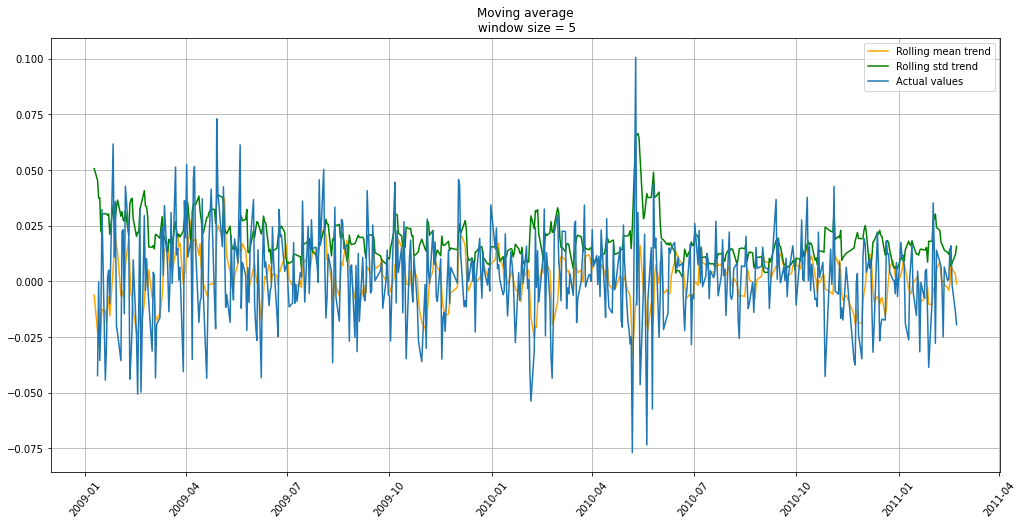

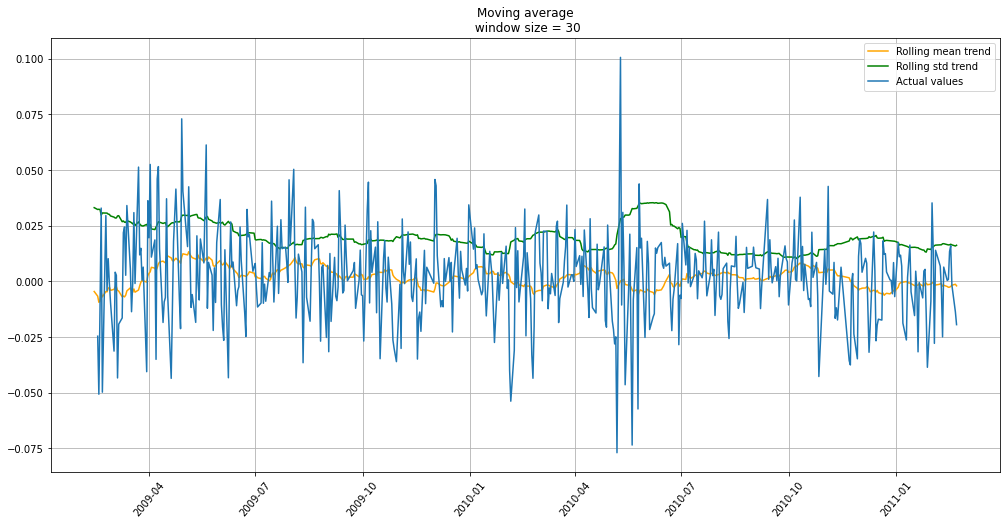

In [10]:
#Smooth by the previous 5 days (by week)
plot_moving_average(stocks_df.ISE_USD_BASED, 5)

#Smooth by the previous month (30 days)
plot_moving_average(stocks_df.ISE_USD_BASED, 30)

### Exponential Smoothing

In [11]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label=f'Alpha {alpha}')
    plt.plot(series.values, label = "Actual")
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
    plt.savefig(f'Exp smoothing with alpha: {alpha}.png', dpi=300)

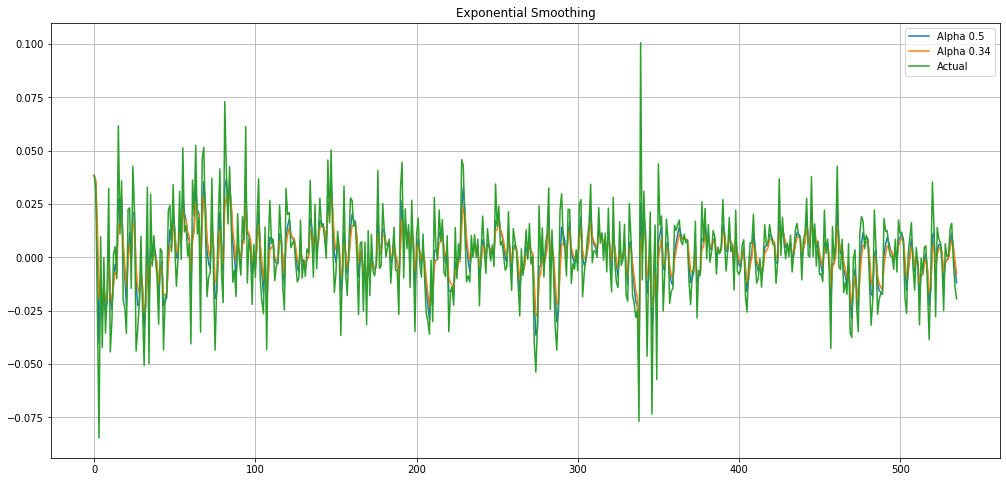

In [12]:
plot_exponential_smoothing(stocks_df.ISE_USD_BASED, [0.5, 0.34])

### Dickey-Fuller Test for Stationarity

In [16]:
# check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
adf_test(stocks_df.ISE_USD_BASED)   

Augmented Dickey-Fuller Test: 
ADF test statistic      -21.510292
p-value                   0.000000
# lags used               0.000000
# observations          535.000000
critical value (1%)      -3.442632
critical value (5%)      -2.866957
critical value (10%)     -2.569655
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [17]:
def tsplot(y, lags=None, figsize=(14, 10), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.savefig('Augmented Dickey-Fuller Test.png', dpi=300)

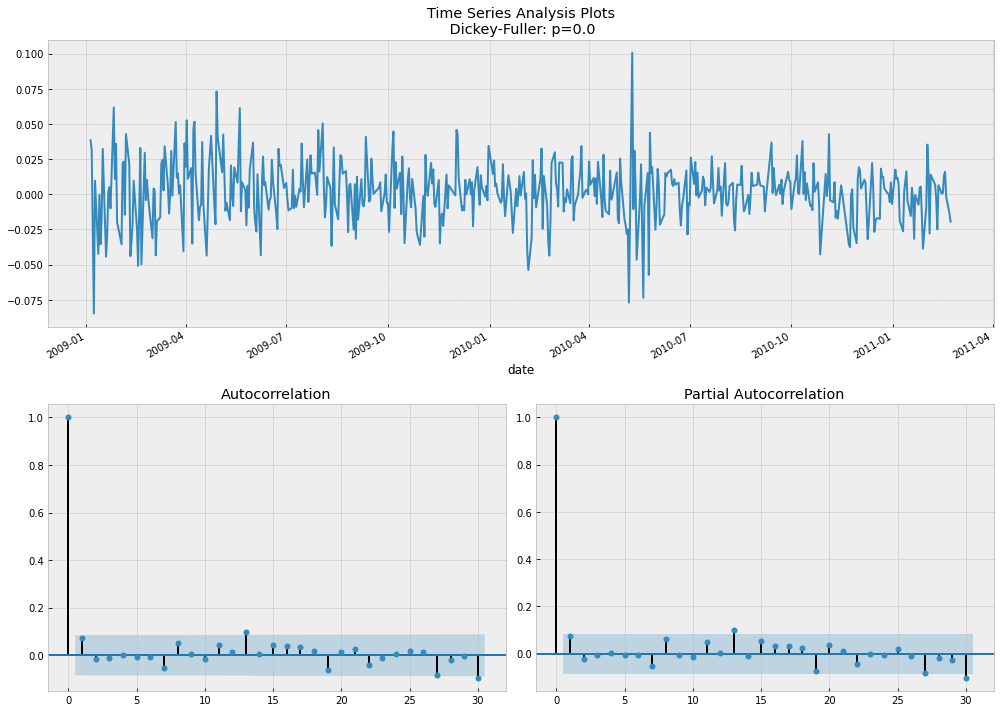

In [18]:
tsplot(stocks_df.ISE_USD_BASED, lags=30)

## Data Prep

In [65]:
stocks_df = stocks_df[:530]
stocks_df.reset_index(drop=True, inplace=True)

In [66]:
ise_df = stocks_df.ISE_USD_BASED.to_frame('ISE_USD_BASED')
ise_df.tail()

,ISE_USD_BASED
525,0.006886
526,-0.003255
527,-0.024921
528,0.006418
529,0.000405


In [67]:
min_max = MinMaxScaler()
ise_df = min_max.fit_transform(np.reshape(ise_df['ISE_USD_BASED'].values, (ise_df.shape[0], 1)))
ise_df = pd.DataFrame(data=ise_df, columns=['ISE_USD_BASED'])

In [68]:
def timeseries_to_supervised(df, n_in, n_out):
   agg = pd.DataFrame()

   for i in range(n_in, 0, -1):
      df_shifted = df.shift(i).copy()
      df_shifted.rename(columns=lambda x: ('%s(t-%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)

   for i in range(0, n_out):
      df_shifted = df.shift(-i).copy()
      if i == 0:
         df_shifted.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
      else:
         df_shifted.rename(columns=lambda x: ('%s(t+%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)
   agg.dropna(inplace=True)
   return agg

In [69]:
n_in = 4
n_out = 1
ise_df = timeseries_to_supervised(ise_df, n_in, n_out)
ise_df.head()

,ISE_USD_BASED(t-4),ISE_USD_BASED(t-3),ISE_USD_BASED(t-2),ISE_USD_BASED(t-1),ISE_USD_BASED(t)
4,0.664154,0.628741,0.314902,0.000000,0.509203
5,0.628741,0.314902,0.000000,0.509203,0.228529
6,0.314902,0.000000,0.509203,0.228529,0.455624
7,0.000000,0.509203,0.228529,0.455624,0.265266
8,0.509203,0.228529,0.455624,0.265266,0.363922


## MLP Approach

### Train - Test Split

In [79]:
X, y = ise_df[[('ISE_USD_BASED(t-%d)' % i) for i in range(n_in, 0, -1)]].values, ise_df['ISE_USD_BASED(t)'].values
print(X.shape, y.shape)

(526, 4) (526,)


In [80]:
len_data = X.shape[0]
print(len_data)
train_size = int(len_data * .8)
print (f'Train size: {train_size}')
print (f'Test size: {len_data - train_size}')

x_train, y_train = X[:train_size, :], y[:train_size]
x_test, y_test = X[train_size:, :], y[train_size:]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

526
Train size: 420
Test size: 106
(420, 4) (420,)
(106, 4) (106,)


### Build MLP

In [81]:
BATCH_SIZE = 1
EPOCHS = 30
LEARNING_RATE = 0.0014
INPUT_DIM = x_train.shape[1]

def create_model(input_dim, learning_rate):
  # Create the model
  model = Sequential(
      [
        layers.Dense(units=5, input_dim=input_dim, activation=activations.relu),
        layers.Dense(2, activation=activations.relu),
        layers.Dense(2, activation=activations.relu),
        layers.Dense(1)
      ]
  )
  
  # Compile the model
  adam = Adam(learning_rate=learning_rate)
  model.compile(loss='mean_squared_error', optimizer=adam, metrics=['RootMeanSquaredError'])
  return model

model = create_model(INPUT_DIM, LEARNING_RATE)

In [82]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/30
420/420 [==============================] - 1s 1ms/step - loss: 0.0734 - root_mean_squared_error: 0.2708
Epoch 2/30
420/420 [==============================] - 0s 1ms/step - loss: 0.0188 - root_mean_squared_error: 0.1372
Epoch 3/30
420/420 [==============================] - 0s 1ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236
Epoch 4/30
420/420 [==============================] - 0s 1ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203
Epoch 5/30
420/420 [==============================] - 0s 1ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201
Epoch 6/30
420/420 [==============================] - 0s 1ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
Epoch 7/30
420/420 [==============================] - 0s 1ms/step - loss: 0.0139 - root_mean_squared_error: 0.1181
Epoch 8/30
420/420 [==============================] - 0s 1ms/step - loss: 0.0138 - root_mean_squared_error: 0.1175
Epoch 9/30
420/420 [==============================] - 0s 1ms/step - loss: 0.0141

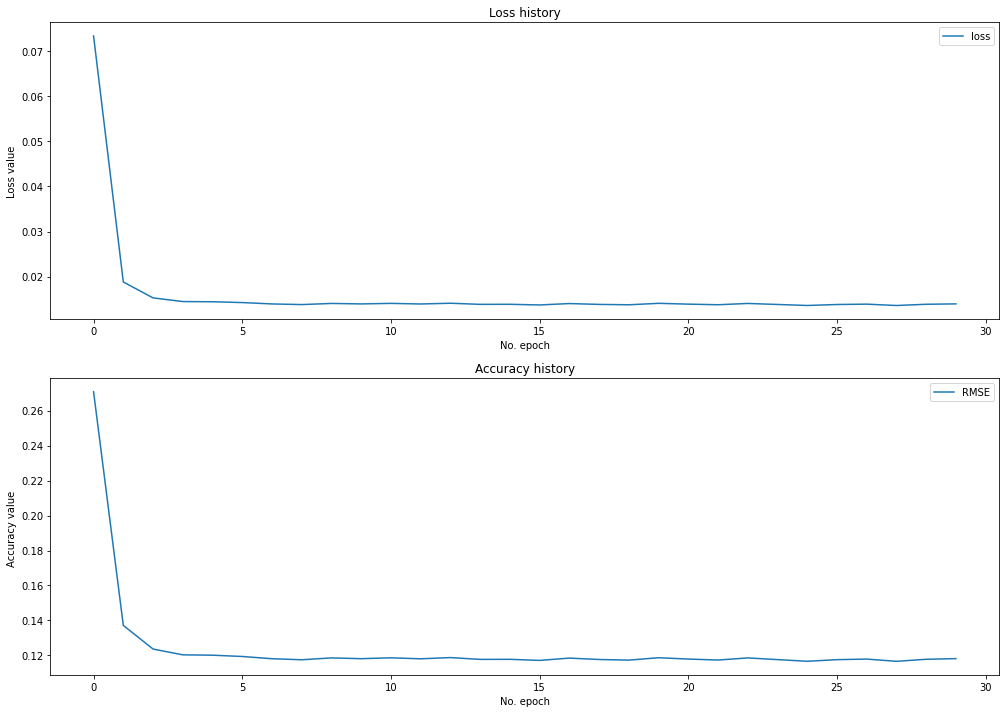

In [83]:
# Plot history: Loss
plt.figure(figsize=(17, 12))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='loss')
plt.title('Loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend()

# Plot history: Accuracy
plt.subplot(2, 1, 2)
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Accuracy history')
plt.ylabel('Accuracy value ')
plt.xlabel('No. epoch')
plt.legend()
plt.savefig('Loss.png', dpi=300)
plt.show()

### Evaluate and Predict

In [84]:
trainPredict = model.predict(x_train, batch_size=BATCH_SIZE)
testPredict = model.predict(x_test, batch_size=BATCH_SIZE)

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

trainPredict = min_max.inverse_transform(trainPredict)
trainY = min_max.inverse_transform(y_train)

testPredict = min_max.inverse_transform(testPredict)
testY = min_max.inverse_transform(y_test)

In [85]:
# calculate error
print(f'Test MSE: {mean_squared_error(testY, testPredict)}')
print(f'Test MAE: {mean_absolute_error(testY, testPredict)}')
print(f'Test R2: {r2_score(testY, testPredict)}')

predicted = np.concatenate((trainPredict,testPredict), axis=0)

original = np.concatenate((trainY,testY),axis=0)
predicted = np.concatenate((trainPredict,testPredict),axis=0)
index = range(0, original.shape[0])

Test MSE: 0.0002848582559363012
Test MAE: 0.013083942821776993
Test R2: -0.02560225677509842


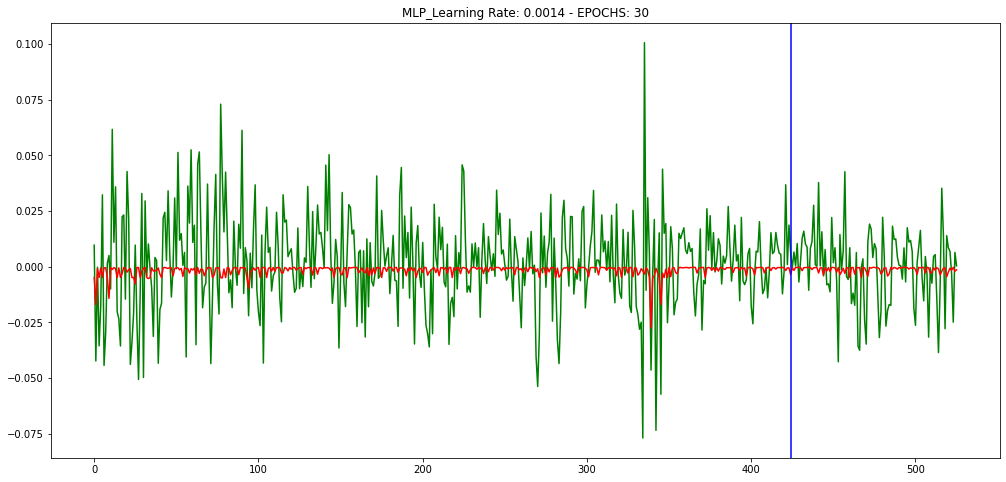

In [86]:
plt.figure(figsize=(17, 8))
plt.plot(index,original, 'g')
plt.plot(index,predicted, 'r')
plt.axvline(ise_df.index[train_size], c="b")
plt.title(f'MLP_Learning Rate: {LEARNING_RATE} - EPOCHS: {EPOCHS}')
plt.savefig(f'MLP_learning_rate_{LEARNING_RATE}_epochs_{EPOCHS}.png', dpi=300)
plt.show()

## SimpleRNN Approach

### Train - Test Split

In [70]:
X, y = ise_df[[('ISE_USD_BASED(t-%d)' % i) for i in range(n_in, 0, -1)]].values, ise_df['ISE_USD_BASED(t)'].values
print(X.shape, y.shape)

(526, 4) (526,)


In [71]:
len_data = X.shape[0]
print(len_data)
train_size = int(len_data * .5)
print (f'Train size: {train_size}')
print (f'Test size: {len_data - train_size}')

x_train, y_train = X[:train_size, :], y[:train_size]
x_test, y_test = X[train_size:, :], y[train_size:]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

526
Train size: 263
Test size: 263
(263, 4) (263,)
(263, 4) (263,)


In [72]:
samples = train_size
steps = 1
print(samples)

features_in = n_in
features_out = n_out

x_train = np.reshape(x_train, (-1, steps, features_in))
y_train = np.reshape(y_train, (samples, steps, features_out))
print(x_train.shape, y_train.shape)

x_test = np.reshape(x_test, (samples, steps, features_in))
y_test = np.reshape(y_test, (samples, steps, features_out))
print(x_test.shape, y_test.shape)

263
(263, 1, 4) (263, 1, 1)
(263, 1, 4) (263, 1, 1)


### Build SimpleRNN

In [73]:
BATCH_SIZE = 1
EPOCHS = 30 
INPUT_SHAPE = [x_train.shape[1], x_train.shape[2]]
LEARNING_RATE = 0.002

def create_simplernn(input_shape, learning_rate):  
  # Create model
  model = Sequential(
      [
        layers.SimpleRNN(units=5, input_shape=input_shape, activation=activations.relu, return_sequences=True),
        layers.Dense(3, activation=activations.relu),
        layers.Dense(3, activation=activations.relu),
        layers.Dense(1),
      ]
  )

  # Compile model
  adam = Adam(learning_rate=learning_rate)
  model.compile(loss='mean_squared_error', optimizer=adam, metrics = ['RootMeanSquaredError'])
  return model

model = create_simplernn(INPUT_SHAPE, LEARNING_RATE)

In [74]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/50
263/263 [==============================] - 1s 1ms/step - loss: 0.1058 - root_mean_squared_error: 0.3253
Epoch 2/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0181 - root_mean_squared_error: 0.1347
Epoch 3/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197
Epoch 4/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196
Epoch 5/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0144 - root_mean_squared_error: 0.1199
Epoch 6/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197
Epoch 7/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197
Epoch 8/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0143 - root_mean_squared_error: 0.1198
Epoch 9/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0144

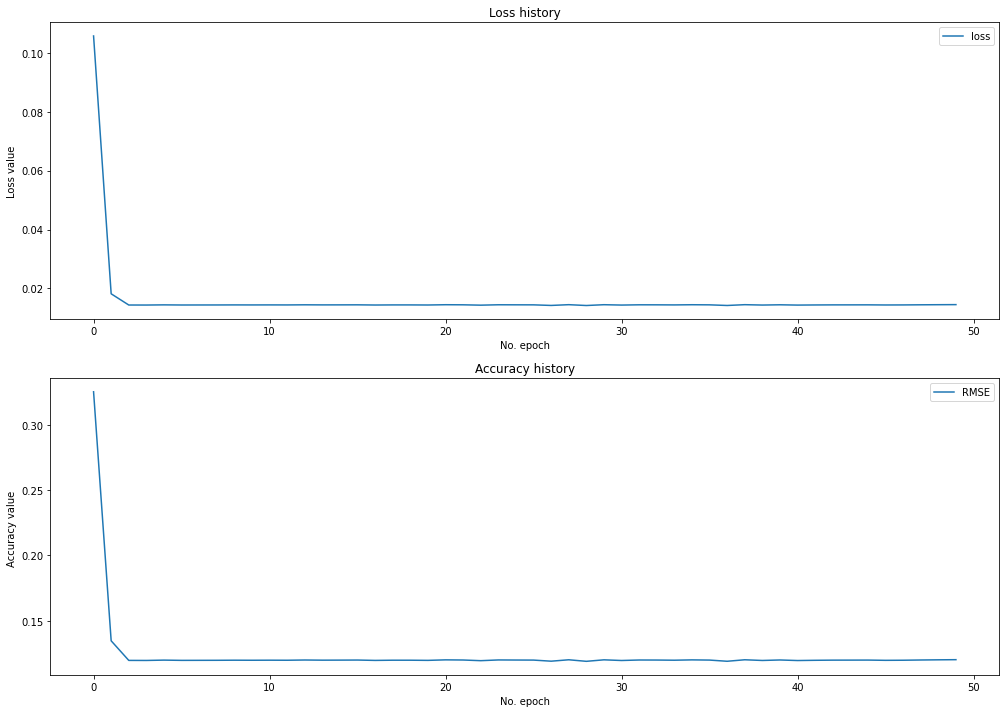

In [75]:
# Plot history: Loss
plt.figure(figsize=(17, 12))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='loss')
plt.title('Loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend()

# Plot history: Accuracy
plt.subplot(2, 1, 2)
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Accuracy history')
plt.ylabel('Accuracy value ')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

### Evaluate and Predict

In [76]:
trainPredict = model.predict(x_train, batch_size=BATCH_SIZE)
testPredict = model.predict(x_test, batch_size=BATCH_SIZE)

# invert predictions
trainPredict = np.reshape(trainPredict, (samples*steps, features_out))
ytr2d = np.reshape(y_train, (samples*steps, features_out))
testPredict = np.reshape(testPredict, (samples*steps, features_out))
yte2d = np.reshape(y_test, (samples*steps, features_out))

trainPredict = min_max.inverse_transform(trainPredict)
trainY = min_max.inverse_transform(ytr2d)
testPredict = min_max.inverse_transform(testPredict)
testY = min_max.inverse_transform(yte2d)

In [77]:
print(f'Test MSE: {mean_squared_error(testY, testPredict)}')
print(f'Test MAE: {mean_absolute_error(testY, testPredict)}')
print(f'Test R2: {r2_score(testY, testPredict)}')

predicted = np.concatenate((trainPredict,testPredict),axis=0)

original = np.concatenate((trainY,testY),axis=0)
predicted = np.concatenate((trainPredict,testPredict),axis=0)
index = range(0, original.shape[0])

Test MSE: 0.00037396279115668133
Test MAE: 0.014084277607328978
Test R2: -0.0036752800420043474


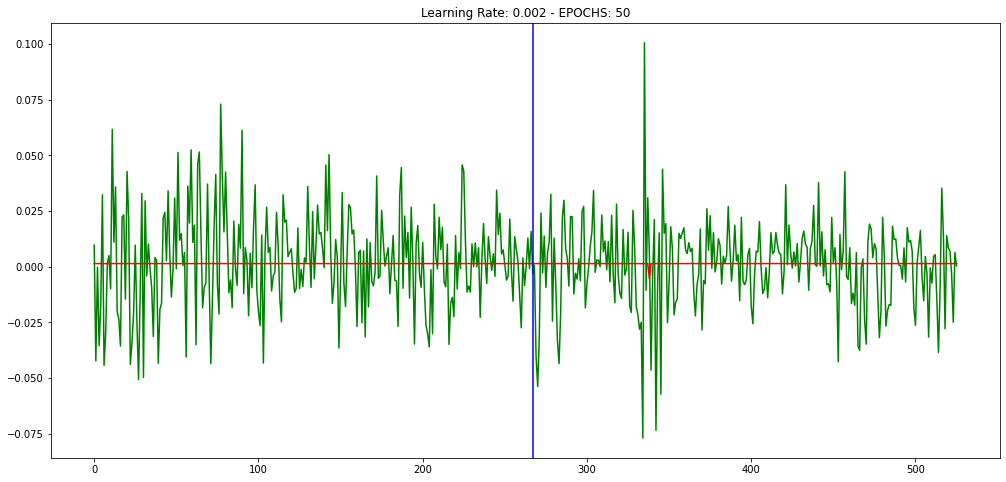

In [78]:
plt.figure(figsize=(17, 8))
plt.plot(index,original, 'g')
plt.plot(index,predicted, 'r')
plt.axvline(ise_df.index[train_size], c="b")
plt.title(f'Learning Rate: {LEARNING_RATE} - EPOCHS: {EPOCHS}')
plt.savefig(f'RNN_learning_rate_{LEARNING_RATE}_epochs_{EPOCHS}.png')
plt.show()